In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import plotly.express as px

In [2]:
df = pd.read_csv('users_subscriptions.csv', sep=';')

In [3]:
df.dtypes

user_id                             object
signup_at                           object
country                             object
platform                            object
app_version                         object
basics_completed                      bool
total_activity_duration_minutes    float64
subscription_id                     object
subscription_start_at               object
subscription_end_at                 object
subscription_type                   object
subscription_price_eur             float64
dtype: object

In [4]:
df.shape

(125000, 12)

In [5]:
df['signup_at'] = pd.to_datetime(df['signup_at'], dayfirst=True)
df['subscription_start_at'] = pd.to_datetime(df['subscription_start_at'], dayfirst=True)
df['subscription_end_at'] = pd.to_datetime(df['subscription_end_at'], dayfirst=True)
df['subscription_duration_days'] = (df['subscription_end_at'] - df['subscription_start_at']).dt.days
df['signup_at_YYYYmm'] = df['signup_at'].apply(lambda dt: dt.replace(day=1))
df['subscription_start_at_YYYYmm'] = df['subscription_start_at'].apply(lambda dt: dt.replace(day=1))
df['time_to_subsribtion_days'] = (df['subscription_start_at']-df['signup_at']).dt.days


In [6]:
df.head(3)
# user_id - unique

,user_id,signup_at,country,platform,app_version,basics_completed,total_activity_duration_minutes,subscription_id,subscription_start_at,subscription_end_at,subscription_type,subscription_price_eur,subscription_duration_days,signup_at_YYYYmm,subscription_start_at_YYYYmm,time_to_subsribtion_days
0,87c4ad99-b20b-4cb4-aac0-e53aacf2a874,2022-11-21,US,iOS,4.52.0,False,13.724117,NaN,NaT,NaT,NaN,NaN,NaN,2022-11-01,NaT,NaN
1,d6b2ad5e-a64c-4657-a753-2a10bf68a1d7,2022-06-25,US,iOS,4.51.0,True,30.052932,NaN,NaT,NaT,NaN,NaN,NaN,2022-06-01,NaT,NaN
2,3abea19d-051a-4d2e-8d16-f7a6c5a43e44,2022-07-15,FI,iOS,4.52.0,False,7.616784,NaN,NaT,NaT,NaN,NaN,NaN,2022-07-01,NaT,NaN


#EDA

## Timeseries

<Axes: xlabel='subscription_start_at', ylabel='cnt'>

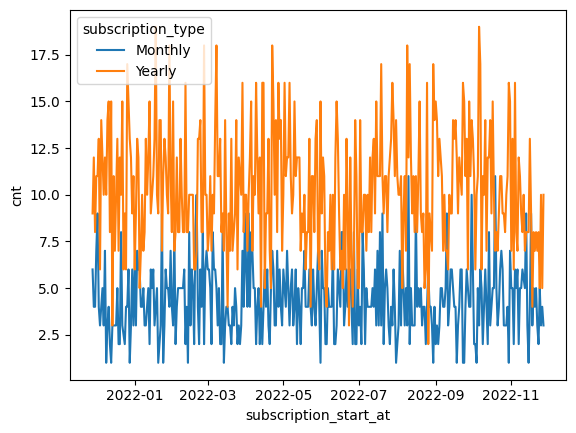

In [7]:
tmp = df[~df['subscription_start_at'].isnull()]\
.groupby(['subscription_start_at', 'subscription_type'])\
.size()\
.reset_index()\
.rename(columns={0:'cnt'})

sns.lineplot(data=tmp, x='subscription_start_at', y='cnt', hue='subscription_type')

<Axes: xlabel='subscription_end_at', ylabel='cnt'>

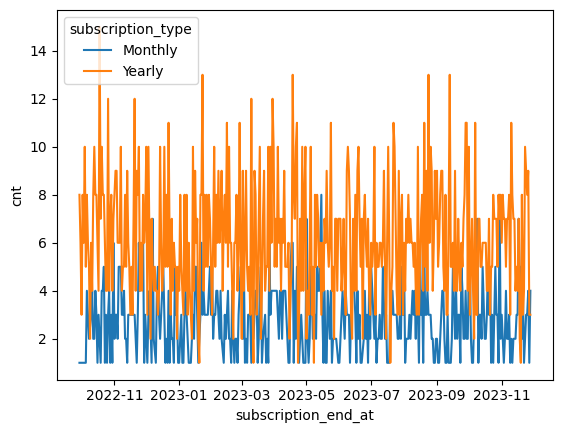

In [8]:
tmp = df[~df['subscription_end_at'].isnull()]\
.groupby(['subscription_end_at', 'subscription_type'])\
.size()\
.reset_index()\
.rename(columns={0:'cnt'})

sns.lineplot(data=tmp, x='subscription_end_at', y='cnt', hue='subscription_type')



In [9]:
print(df['subscription_start_at'].max())
print(df['subscription_end_at'].min())

# anomaly. Subscription_start_at and subscription_end_at intersect only from Oct to Nov 2022

2022-11-27 00:00:00
2022-09-29 00:00:00


In [10]:
df[~df['subscription_id'].isnull()][['subscription_start_at', 'subscription_end_at']]
# why subscription_end_at is NaN?

,subscription_start_at,subscription_end_at
49,2022-07-10,2023-10-07
98,2022-08-16,2023-06-27
107,2021-12-09,2023-09-13
139,2022-10-17,2022-10-17
144,2022-03-09,2023-03-14
...,...,...
124864,2022-11-21,NaT
124910,2022-10-28,2023-05-05
124929,2022-04-26,NaT
124965,2022-07-04,2023-04-04


In [11]:
print(df[~df['subscription_id'].isnull()].shape)
print(df[~df['subscription_start_at'].isnull()].shape)
print(df[~df['subscription_end_at'].isnull()].shape)

(5350, 16)
(5350, 16)
(3728, 16)


## Metrics

<Axes: >

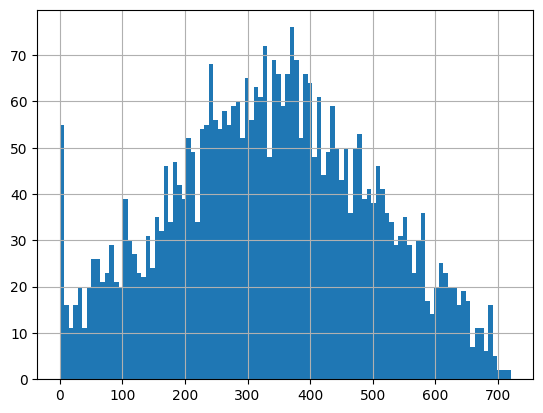

In [12]:
df['subscription_duration_days'].dropna().hist(bins=100)
# There is an anomaly around 0
# In real case we could analyse this animaly, but for test task I will drop it

<Axes: xlabel='subscription_start_at_YYYYmm', ylabel='CR_month'>

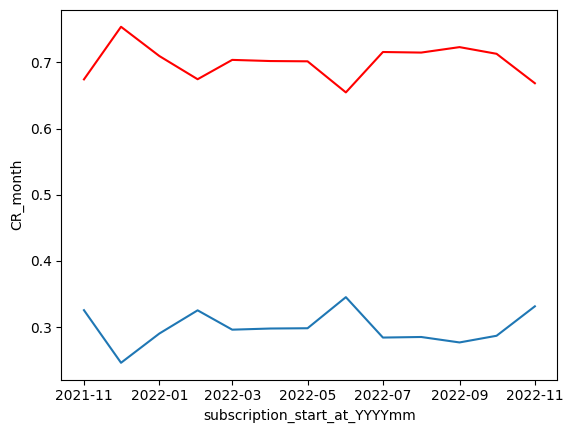

In [13]:
df_month = df.query('subscription_type == "Monthly"').groupby(['subscription_start_at_YYYYmm']).agg(subscription_cnt_month=('subscription_id', 'count'))
df_year = df.query('subscription_type == "Yearly"').groupby(['subscription_start_at_YYYYmm']).agg(subscription_cnt_year=('subscription_id', 'count'))

df_users = df.groupby(['subscription_start_at_YYYYmm']).agg(n_customers=('user_id', 'nunique'))

tmp = df_users\
  .merge(df_month, left_index=True, right_index=True, how='left')\
  .merge(df_year, left_index=True, right_index=True, how='left')

tmp['CR_month'] = tmp['subscription_cnt_month'] / tmp['n_customers']
tmp['CR_year'] = tmp['subscription_cnt_year'] / tmp['n_customers']

sns.lineplot(data=tmp, x='subscription_start_at_YYYYmm', y='CR_month')
sns.lineplot(data=tmp, x='subscription_start_at_YYYYmm', y='CR_year', color='red')

<Axes: >

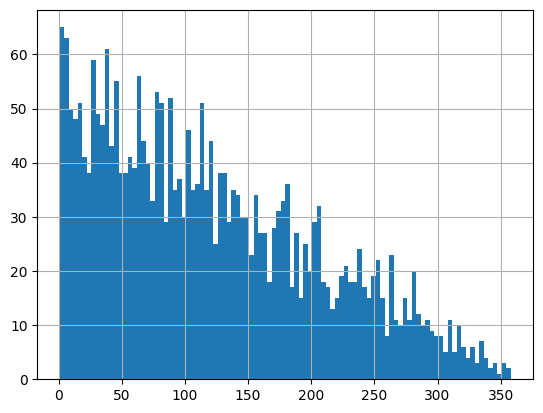

In [14]:
df.query('time_to_subsribtion_days > 0')['time_to_subsribtion_days'].dropna().hist(bins=100)

<Axes: xlabel='signup_at_YYYYmm', ylabel='time_to_subsribtion_days'>

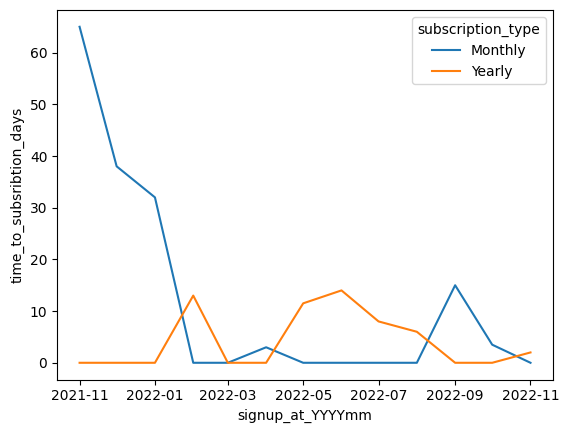

In [15]:
tmp = df[~df['subscription_start_at'].isnull()]\
.groupby(['signup_at_YYYYmm', 'subscription_type'])['time_to_subsribtion_days'].median()\
.reset_index()

sns.lineplot(data=tmp, x='signup_at_YYYYmm', y='time_to_subsribtion_days', hue='subscription_type')

#How long does it take for users to complete the basics?

An average activity duration to complete the basis is about 1 hour. Maximum is a little bit more that 2 hour. The most people need 77 mins (80 persentile)

Also there is an anomaly values around 0 between Jan 2022 and Nov 2022 every day. I will remove this anomaly data for the follow analisys.

<Axes: >

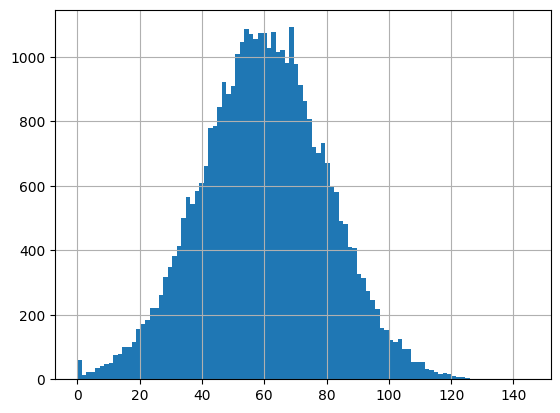

In [17]:
df.query('basics_completed == True').total_activity_duration_minutes.hist(bins=100)

# An anomaly around total_activity_duration_minutes = 0 in the histplot

<Axes: xlabel='signup_at', ylabel='cnt'>

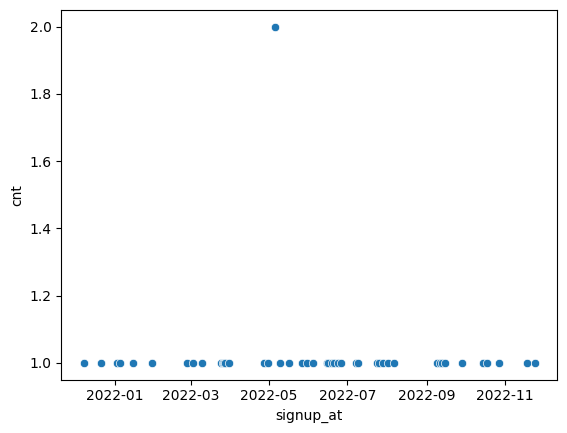

In [18]:
tmp = df.query('basics_completed == True and total_activity_duration_minutes == 0')\
.groupby('signup_at')\
.size()\
.reset_index()\
.rename(columns={0:'cnt'})

sns.scatterplot(data=tmp, x='signup_at', y='cnt')

# An anomaly around total_activity_duration_minutes = 0

In [19]:
df\
.query('basics_completed == True and total_activity_duration_minutes > 0')\
.total_activity_duration_minutes.describe()

count    37544.000000
mean        60.064019
std         19.945642
min          0.101287
25%         46.502430
50%         59.937762
75%         73.505481
max        144.769565
Name: total_activity_duration_minutes, dtype: float64

In [20]:
df\
.query('basics_completed == True and total_activity_duration_minutes > 0')\
.total_activity_duration_minutes\
.quantile(0.8)

77.0163103794599

In [21]:
df.query('total_activity_duration_minutes > 0', inplace=True)

# What is the total revenue generated by the app over the past one month?

Total revenue is around 28_400 euro for Nov 2023.

I don't know what subscription_end_at is NaN means. I suppose if subscription_end_at is NaN then the subscription is valid today.

In [22]:
tmp = df.copy()
tmp['subscription_end_at'] = df.loc[~df['subscription_id'].isna()]['subscription_end_at'].fillna('2023-12-01')

In [23]:
tmp.loc[tmp.subscription_end_at >= '2023-11-01']\
.apply(lambda row: row['subscription_price_eur']/12 if row['subscription_type'] == 'Yearly' else  row['subscription_price_eur'], axis=1).sum()


28395.639999999996

# What is the churn rate for users with Yearly subscriptions? Assuming that churn is defined as an unsubscription within the first year.

Churn Rate is 39%

In [24]:
df.query('subscription_type == "Yearly" and subscription_duration_days < 365')['user_id'].count()

1412

In [25]:
df.query('subscription_type == "Yearly"')['user_id'].count()

3608

In [26]:
1412 / 3608

0.39135254988913526

# What is the average lifetime value (LTV) for Monthly users and how many times on average users successfully renew their subscription? Assuming that renewal is defined as the second and so forth payments.

Average LTV is 267 euro per users. They successfully renew their subscription 12 months.

<Axes: >

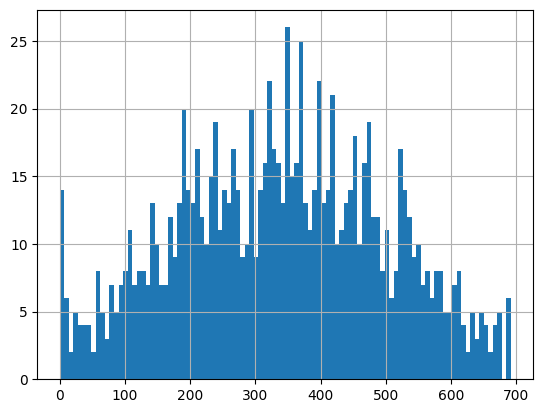

In [27]:
df.query('subscription_type == "Monthly"')['subscription_duration_days'].dropna().hist(bins=100)
# remove the anomaly around 0

average users successfully renew their subscription is 11 months, if I exclude subscription_end_at = None

In [28]:
tmp = df.query('subscription_type == "Monthly" and subscription_duration_days == 0')\
.groupby(['subscription_start_at', 'platform'])\
.size()\
.reset_index()\
.rename(columns={0:'cnt'})

fig = px.scatter(x=tmp['subscription_start_at'], y=tmp['cnt'], color=tmp['platform'])
fig.show()

# An anomaly around total_activity_duration_minutes = 0 has the same interval to repeat.
# Possibly it is test subscription every 2 weeks after deploing new features.

In [29]:
df.query(
    'subscription_type == "Monthly" and subscription_duration_days > 0'
)['subscription_duration_days'].mean()

341.82758620689657

In [30]:
tmp = df.query('subscription_type == "Monthly" and subscription_duration_days > 0')

<Axes: >

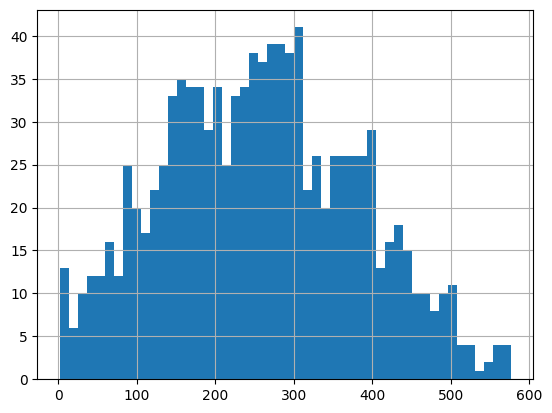

In [31]:
(tmp['subscription_price_eur'] * tmp['subscription_duration_days']/30).hist(bins=50)

In [32]:
(tmp['subscription_price_eur'] * np.ceil(tmp['subscription_duration_days']/30)).mean()
# total_subscription_price_eur / n_users

267.9215325670498

In [33]:
np.ceil(tmp['subscription_duration_days']/30).mean()

11.869731800766283

# What else looks insightful or contradictory to you in the dataset?

- The sample data was chosen not randomly. It сonfirm timelines plots and the fields subscription_start_at and subscription_end_at. I see shift between two plots.
- Count of subsribers don't have trend and season. I would be note that it might be an anomaly behaviour.
